### In-out optimization
Exploration of performance-increasing methods for in-out validation. This is one of the bottlenecks in the tracking pipeline. It would be good to cut down on the resource requirements while making it still accurate.

### 1. Imports

In [90]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from helpers.limbus_detection import detect_circle
from helpers.misc import get_in_out_intensity_diff


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


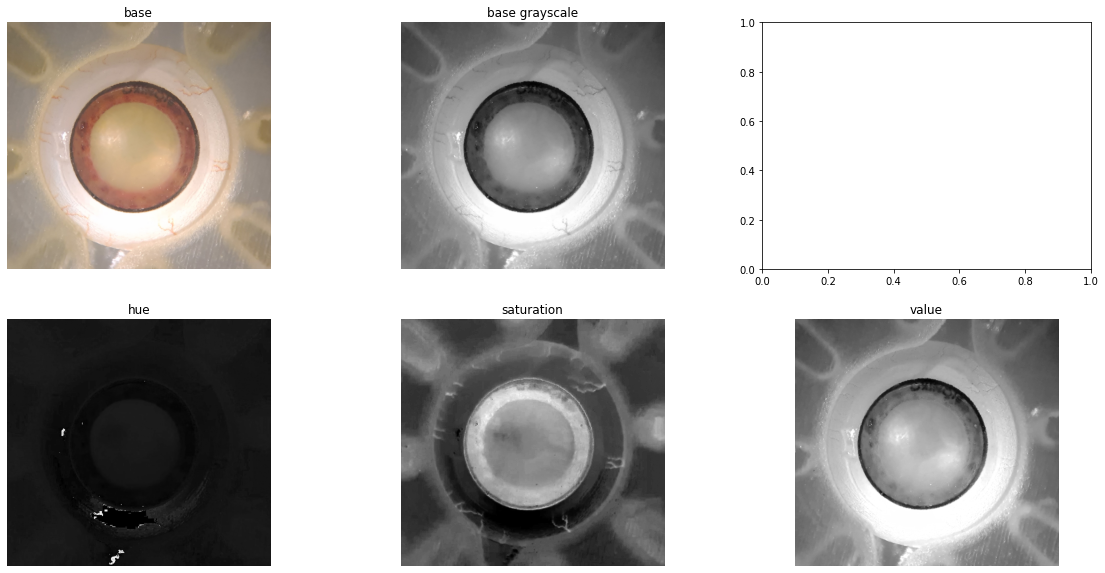

size: 528x496


In [91]:
scale = 0.33
# scale = 1.0

base = cv2.imread('data/artificial/base2.jpeg', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0, 0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)
      ) = plt.subplots(2, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

This constant is defined to be consistent across all of the trials.

In [92]:
CIRCLE_WIDTH_TO_RADIUS_RATIO = 0.04

### 2. Circle detection using Hough transform without any validation

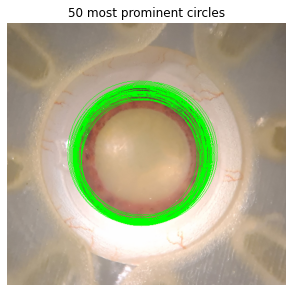

In [93]:
DRAW_CIRCLES = 50

circles = detect_circle(base_value, return_all=True)

base_rgb_copy = base_rgb.copy()
for circle in circles[:DRAW_CIRCLES]:
    cv2.circle(base_rgb_copy, (round(circle[0]), round(
        circle[1])), round(circle[2]), (0, 255, 0))

_, plot = plt.subplots(1, 1, figsize=(5, 10))
plot.set_title('%d most prominent circles' % DRAW_CIRCLES)
plot.imshow(base_rgb_copy)
plot.axis('off')

plt.show()

### 3. Analysis of in-out naive implementation

In [94]:
center = (round(circles[0, 0]), round(circles[0, 1]))
radius = round(circles[0, 2])

%timeit get_in_out_intensity_diff(base_value, center, radius, circle_width_to_radius_ratio=CIRCLE_WIDTH_TO_RADIUS_RATIO)

194 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 4. Point sampling optimization
Only a few pixels along the ring are sampled instead of all of them. This approach does not require initializing whole mask which is quite expensive.

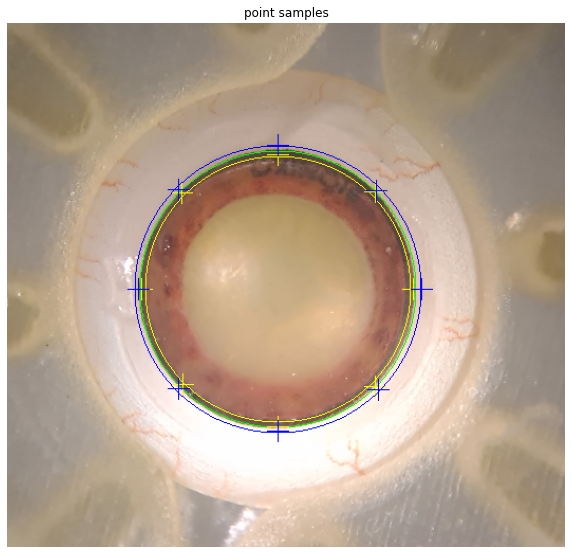

In [95]:
SAMPLED_POINTS = 8

correct_circle = circles[2]
center = (round(correct_circle[0]), round(correct_circle[1]))
radius = round(correct_circle[2])
circle_width = int(CIRCLE_WIDTH_TO_RADIUS_RATIO*radius)

xs_s = np.cos(2 * np.pi * np.arange(0, SAMPLED_POINTS, 1) / SAMPLED_POINTS)
ys_s = np.sin(2 * np.pi * np.arange(0, SAMPLED_POINTS, 1) / SAMPLED_POINTS)

scale = np.random.rand(SAMPLED_POINTS) * circle_width + radius - circle_width
xs_in = (xs_s * scale + center[0]).round().astype(np.int16)
ys_in = (ys_s * scale + center[1]).round().astype(np.int16)

scale = np.random.rand(SAMPLED_POINTS) * circle_width + radius
xs_out = (xs_s * scale + center[0]).round().astype(np.int16)
ys_out = (ys_s * scale + center[1]).round().astype(np.int16)

base_rgb_copy = base_rgb.copy()
cv2.circle(base_rgb_copy, center, radius, (0, 255, 0))
cv2.circle(base_rgb_copy, center, radius - circle_width, (255, 255, 0))
for i in range(SAMPLED_POINTS):
    cv2.drawMarker(base_rgb_copy, (xs_in[i], ys_in[i]), (255, 255, 0))
cv2.circle(base_rgb_copy, center, radius + circle_width, (0, 0, 255))
for i in range(SAMPLED_POINTS):
    cv2.drawMarker(base_rgb_copy, (xs_out[i], ys_out[i]), (0, 0, 255))


_, plot = plt.subplots(1, 1, figsize=(10, 10))
plot.set_title('point samples')
plot.imshow(base_rgb_copy)
plot.axis('off')

plt.show()

### 5. In-out difference using sampling

In [96]:
def get_in_out_intensity_diff_optim(grey: np.array, center: tuple, radius: float, sampled_points: int = 8,
                                    circle_width_to_radius_ratio: float = CIRCLE_WIDTH_TO_RADIUS_RATIO) -> float:
    assert isinstance(sampled_points, int) and sampled_points > 0, \
        'sampled_points must be a natural number'

    circle_width = round(circle_width_to_radius_ratio*radius)

    # getting coordinates evenly spread along the ring
    xs_s = np.cos(2 * np.pi * np.arange(0, sampled_points, 1) / sampled_points)
    ys_s = np.sin(2 * np.pi * np.arange(0, sampled_points, 1) / sampled_points)

    # randomly sampling distance from the center for better robustness
    scale = np.random.rand(sampled_points) * \
        circle_width + radius - circle_width
    xs_in = (xs_s * scale + center[0]).round().astype(np.int16)
    ys_in = (ys_s * scale + center[1]).round().astype(np.int16)
    valid = np.logical_and.reduce(
        (xs_in >= 0, ys_in >= 0, xs_in < grey.shape[1], ys_in < grey.shape[0]))
    in_intensity = np.mean(grey[(ys_in[valid], xs_in[valid])])

    scale = np.random.rand(sampled_points) * circle_width + radius
    xs_out = (xs_s * scale + center[0]).round().astype(np.int16)
    ys_out = (ys_s * scale + center[1]).round().astype(np.int16)
    valid = np.logical_and.reduce(
        (xs_out >= 0, ys_out >= 0, xs_out < grey.shape[1], ys_out < grey.shape[0]))
    out_intensity = np.mean(grey[(ys_out[valid], xs_out[valid])])

    return out_intensity - in_intensity

### 6. Analysis of precision based on number of points sampled

In [97]:
TRIALS = 1000
SAMPLED_POINTS_D = list(int(e) for e in 2**np.arange(1, 15, 1))

correct_circle = circles[2]
center = (round(correct_circle[0]), round(correct_circle[1]))
radius = round(correct_circle[2])

true_in_out = get_in_out_intensity_diff(base_value, center, radius,
                                        circle_width_to_radius_ratio=CIRCLE_WIDTH_TO_RADIUS_RATIO)
print('true in-out: %f' % true_in_out)

sampled_points = []
optimized_in_outs = []
for sp in SAMPLED_POINTS_D:
    for _ in range(TRIALS):
        sampled_points.append(sp)
        optimized_in_outs.append(
            get_in_out_intensity_diff_optim(base_value, center, radius, sampled_points=sp))

df = pd.DataFrame({'sampled_points': sampled_points,
                  'in_out': optimized_in_outs})
df.groupby(['sampled_points'], as_index=False).agg({'in_out': ['mean', 'std']})

true in-out: 86.125117


sampled_points     in_out           
                        mean        std
0               2  77.084000  22.676423
1               4  87.283000  16.024308
2               8  87.690625  10.820657
3              16  84.334438   8.116378
4              32  86.466063   5.793653
5              64  86.990938   3.925286
6             128  87.351430   2.919544
7             256  87.020980   2.125266
8             512  87.219098   1.485381
9            1024  87.242364   1.031046
10           2048  87.261509   0.746382
11           4096  87.261790   0.546069
12           8192  87.223394   0.361990
13          16384  87.226518   0.255361

Gives nice and stable results for relatively low number of sampled points. However, something seems to be off about the method, because it converges to slightly different value. Needs further debugging. Seems promising, though.

### 7. Computation differences (study in robustness)

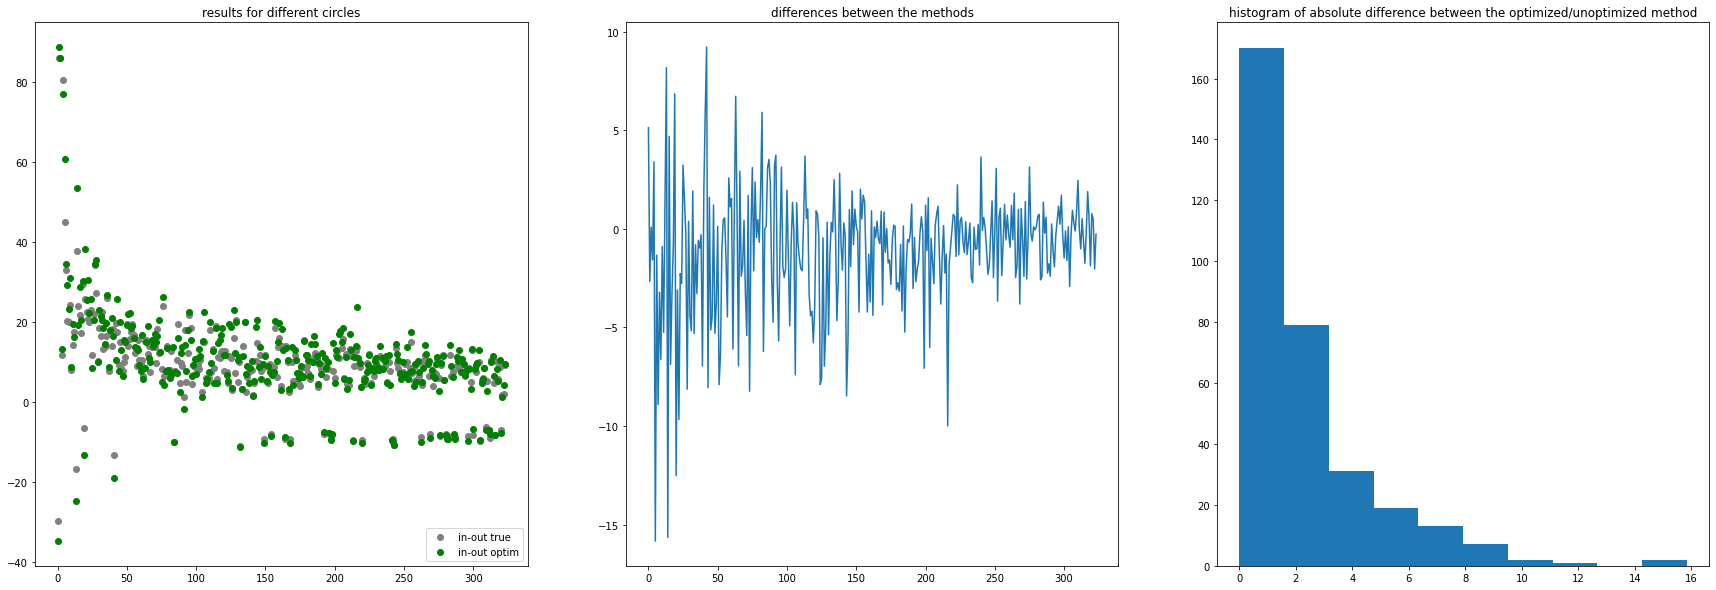

In [104]:
sampled_points = 128

in_out_true = []
in_out_optim = []
for circle in circles:
    center = (round(circle[0]), round(circle[1]))
    radius = round(circle[2])
    in_out_true.append(get_in_out_intensity_diff(base_value, center, radius,
                                                 circle_width_to_radius_ratio=CIRCLE_WIDTH_TO_RADIUS_RATIO))
    in_out_optim.append(get_in_out_intensity_diff_optim(
        base_value, center, radius, sampled_points=sampled_points))

in_out_true = np.array(in_out_true)
in_out_optim = np.array(in_out_optim)

fig, plots = plt.subplots(1, 3, figsize=(30, 10))
plots[0].set_title('results for different circles')
plots[0].scatter(np.arange(0, len(in_out_true), 1),
                 in_out_true, color='gray', label='in-out true')
plots[0].scatter(np.arange(0, len(in_out_optim), 1), in_out_optim,
                 color='green', label='in-out optim')
plots[0].legend(loc='lower right')

plots[1].set_title('differences between the methods')
plots[1].plot(in_out_true - in_out_optim)

plots[2].set_title(
    'histogram of absolute difference between the optimized/unoptimized method')
plots[2].hist(np.abs(in_out_true - in_out_optim))

plt.show()

### 8. Performance analysis of the optimized method

In [105]:
SAMPLED_POINTS = 128
center = (round(circles[0, 0]), round(circles[0, 1]))
radius = round(circles[0, 2])

%timeit get_in_out_intensity_diff_optim(base_value, center, radius, sampled_points=SAMPLED_POINTS)

71 µs ± 239 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This basically means that a speed-up of 4x can be achieved with the new method.

### 9. Optimized v. unoptimized method video demo

In [106]:
cap = cv2.VideoCapture('data/artificial/bioniko_input_long.mp4')
_, frame = cap.read()

while cap.isOpened():
    ret, frame = cap.read()

    # visualization
    base_true = frame.copy()
    base_optim = frame.copy()

    # performance measurement
    timer = cv2.getTickCount()

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    value = hsv[:, :, 2]

    # fetching all circles
    circles = detect_circle(value, return_all=True)
    if circles is not None:
        circles = circles[:int(0.25*len(circles))]

        # in-out methods
        true_in_outs = []
        optim_in_outs = []
        for circle in circles:
            center = (round(circle[0]), round(circle[1]))
            radius = round(circle[2])
            true_in_outs.append(get_in_out_intensity_diff(
                value, center, radius, circle_width_to_radius_ratio=CIRCLE_WIDTH_TO_RADIUS_RATIO))
            optim_in_outs.append(get_in_out_intensity_diff_optim(
                value, center, radius, sampled_points=128,
                circle_width_to_radius_ratio=CIRCLE_WIDTH_TO_RADIUS_RATIO))

        # visualizations
        true_circle = circles[np.nanargmax(true_in_outs)]
        cv2.circle(base_true, (round(true_circle[0]), round(
            true_circle[1])), round(true_circle[2]), (0, 255, 0))

        optim_circle = circles[np.nanargmax(optim_in_outs)]
        cv2.circle(base_optim, (round(optim_circle[0]), round(
            optim_circle[1])), round(optim_circle[2]), (0, 255, 0))

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    cv2.imshow('unoptimized', base_true)
    cv2.imshow('optimized', base_true)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)